<a href="https://colab.research.google.com/github/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Code/Exercise1/ExerciseSheet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPSA 2021 - Exercise 1

The goal of this exercise is to get used to practical image processing in
*python / numpy / scipy*. 

Do **NOT** use additional third party libraries such as *OpenCV* or
*scikit-image* for the coding tasks in this course!



## 0 - Warm Up

In [2]:
import imageio 
import numpy as np
import scipy.ndimage as img
import matplotlib.pyplot as plt

import timeit, functools

In [ ]:
!wget https://github.com/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Exercises/'0 Data'/portrait.png

--2021-11-05 11:46:07--  https://github.com/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Exercises/0%20Data/portrait.png
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-11-05 11:46:07 ERROR 404: Not Found.



In [3]:
def imageRead(imgname, pilmode ='L', arrtype=np.float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

To display an intensity image use:

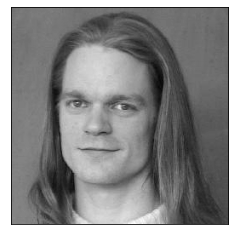

In [4]:
arrF = imageRead("portrait.png")
plt.imshow(arrF / 255, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

To display an (RGB) color image use:

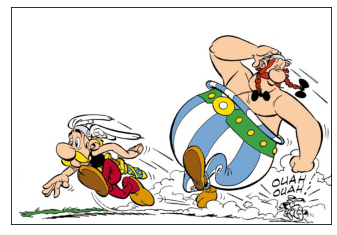

In [5]:
arrF = imageRead('asterixRGB.png', pilmode='RGB')
plt.imshow(arrF / 255)
plt.xticks([]); plt.yticks([])
plt.show()

## 1 - The emboss effect

In [6]:
filename = "portrait.png"

arrF = imageRead(filename)
print(f"The image '{filename}' has {arrF.shape[0]} rows and {arrF.shape[1]} columns.")

The image 'portrait.png' has 256 rows and 256 columns.


### Different emboss implementations

In [7]:
def embossV1(arrF):
    """
    Naive Emboss: Iterate through all cells and explicitly compute the 
    every gradient. Do so by computing the difference between the intensity
    values in the lower right and upper left cell.    
    Add 255/2 = 128 to compensate for the induced value shift.
    Clip the results to the interval [0, 255].

    Slow implementation.
    """
    M, N = arrF.shape
    arrG = np.zeros((M,N))

    for i in range(1,M-1):
        for j in range(1,N-1):
            arrG[i,j] = 128 + arrF[i+1,j+1] - arrF[i-1,j-1]
            arrG[i,j] = np.maximum(0, np.minimum(255, arrG[i,j]))

    return arrG

In [8]:
def embossV2(arrF):
    """
    Numpythonic Emboss: Use python-slicing to compute all gradients 
    at once by subtracting the upper left (M-2 x N-2)-matrix
    from the lower right (M-2 x N-2)-matrix - to yield the gradients
    of the central (M-1 x N-1)-matrix. 
    Add 255/2 = 128 to compensate for the induced value shift.
    Clip the results to the interval [0, 255].

    Fast implementation.
    """
    M, N = arrF.shape
    arrG = np.zeros((M,N))

    arrG[1:M-1,1:N-1] = 128 + arrF[2:,2:] - arrF[:-2,:-2]
    arrG = np.maximum(0, np.minimum(255, arrG))

    return arrG

In [9]:
def embossV3(arrF):
    """
    Convolution Emboss: similar to CNNs, use a 3x3-mask which sweeps
    over all non-border-cells.
    Add 255/2 = 128 to compensate for the induced value shift.
    Clip the results to the interval [0, 255].

    Fast and practival (generalizable) implementation.
    """
    mask = np.array([[-1, 0,  0],
                     [ 0, 0,  0],
                     [ 0, 0, +1]])

    arrG = 128 + img.correlate(arrF, mask, mode='reflect')
    arrG = np.maximum(0, np.minimum(255, arrG))

    return arrG

In [10]:
def embossV4(arrF):
    """
    Numpythonic Emboss: Use python-slicing to compute all gradients 
    at once by subtracting the upper left (M-1 x N-1)-matrix
    from the lower right (M-1 x N-1)-matrix - to yield the gradients
    of the central (M-1 x N-1)-matrix. Notice, that only this matrix is stored, 
    thus the dimensions are diminished in each direction by two and no black
    boreder will remain. 
    
    Add 255/2 = 128 to compensate for the induced value shift.
    
    Clip the results to the interval [0, 255], by using
    pythons array boolean indexing. (Masks for the corner values.)
    """
    arrG = 128 + arrF[2:,2:] - arrF[:-2,:-2]
    arrG[arrG<  0] =   0
    arrG[arrG>255] = 255

    return arrG

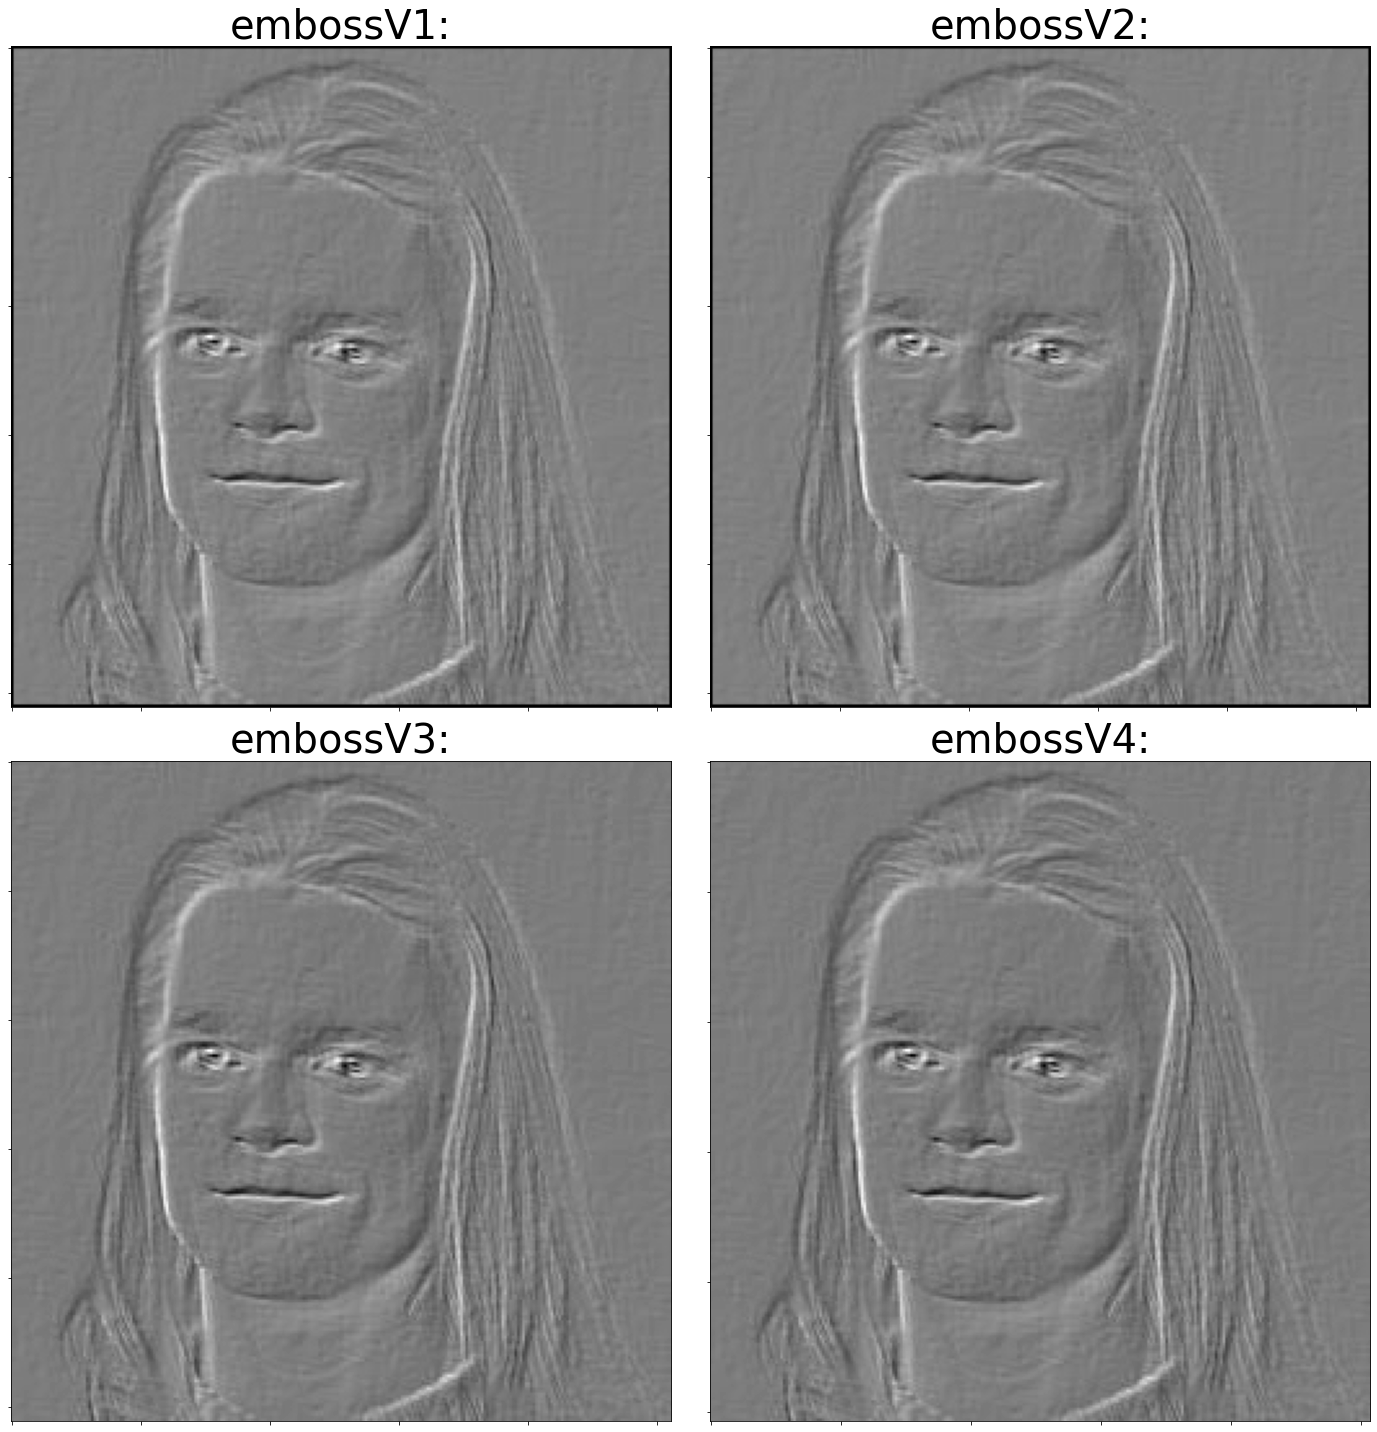

In [11]:
methods = [embossV1, embossV2, embossV3, embossV4]
arrGs = [arrF] * len(methods)

fig, axs = plt.subplots(int(0.5*len(methods)), 2, figsize=(20,20))

for i, mtd in enumerate(methods):
    arrGs[i] = mtd(arrF)

    ax = axs[int(i/2), i%2]
    ax.imshow(arrGs[i], cmap='gray')    
    ax.set_title(f"{mtd.__name__}:", fontsize=40)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

Notice that method `embossV3` and `embossV4` do not result in a black border.

A closer examination shows that `embossV4` trimms the image. Its results has dimension $254\times 254$.
Only `embossV3` computes non-zero values for the border.

In [12]:
for i, arrG in enumerate(arrGs):
    print(f"Image dimensions when using method embossV{i+1}: {arrG.shape}")
    print("\tDoes %screate a black border.\n\n"%("not " if arrG[0][100] != 0 else ""))

Image dimensions when using method embossV1: (256, 256)
	Does create a black border.


Image dimensions when using method embossV2: (256, 256)
	Does create a black border.


Image dimensions when using method embossV3: (256, 256)
	Does not create a black border.


Image dimensions when using method embossV4: (254, 254)
	Does not create a black border.




## 2 - Timing the emboss effect

### 2 a)

In [14]:
def runtime_evaluation(data, methods, nRep, nRun):
    print("Mean runtimes for:")
    for method in methods:
        ts = timeit.Timer(functools.partial(method, data)).repeat(nRep, nRun)
        print(f"{method.__name__}:\t{min(ts) / nRun}\t[sec]")

In [15]:
mtds = [embossV1, embossV2, embossV3, embossV4]
nRep = 3
nRun = 100

In [16]:
filename0 = "portrait.png"
arrF0 = imageRead(filename0)

runtime_evaluation(arrF0, methods, nRep, nRun)

Mean runtimes for:
embossV1:	0.29502199981999977	[sec]
embossV2:	0.0006990899799995987	[sec]
embossV3:	0.0009541637400002401	[sec]
embossV4:	0.00033126961999982993	[sec]


### 2 b)

In [18]:
filename1 = "asterix.png"
arrF1 = imageRead(filename1)

runtime_evaluation(arrF1, methods, nRep, nRun)

KeyboardInterrupt: ignored

### 2 c)

In [19]:
n0, m0 = arrF0.shape
n1, m1 = arrF1.shape
print(f"The image '{filename0}' has dimensions {n0}x{m0} and thus {n0*m0} cells.")
print(f"The image '{filename1}' has dimensions {n1}x{m1} and thus {n1*m1} cells.")
print(f"That is almost {round(n1*m1/(n0*m0))}-times as much!")

The image 'portrait.png' has dimensions 256x256 and thus 65536 cells.
The image 'asterix.png' has dimensions 496x730 and thus 362080 cells.
That is almost 6-times as much!


These runtimes grow approximately linear wrt to the number of cells. That is as expected, since all implementations iterate over all pixels and thus have runtime complexity in $\mathcal{O}(mn)$.

## 3 - Working with RGB color images

(496, 730, 3)


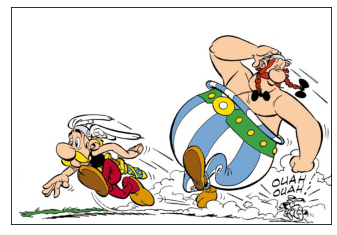

In [ ]:
arrF = imageRead('asterixRGB.png', pilmode='RGB')

print(arrF.shape)
plt.imshow(arrF / 255)
plt.xticks([]); plt.yticks([])
plt.show()

(496, 730, 3)


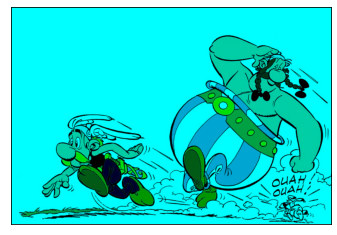

In [ ]:
arrG = np.copy(arrF)
arrG[:,:,0] = 0

print(arrG.shape)
plt.imshow(arrG / 255)
plt.xticks([]); plt.yticks([])
plt.show()

We can see, that all values of the third RGB-channel were set to zero. Thus the **image does no longer contain the color red**. Red is replaced by black. 

Notice that asterix's trousers are black. And the white background is only composed out of the colors green and blue.

Explanation of the code `arrG[:,:,0] = 0` operates on all cells (`[:,:]`) and the first (zeroth) of the color channels (which are stored in the thrid position. Thus the red-value for every pixel is set to zero/black.

## 4 - Getting used to slicing (part 1)

In [24]:
arrF = imageRead('asterix.png')
arrG = imageRead('portrait.png')

arrH = np.copy(arrF)
m, n = arrG.shape

i, j = 100, 200
arrH[i:i+m,j:j+n] = arrG

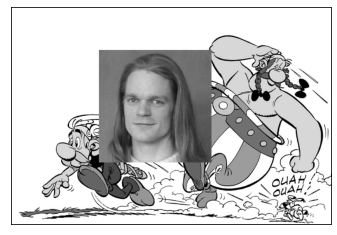

In [25]:
plt.imshow(arrH / 255, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

## 5 - Getting used to slicing (part 2)

In [27]:
arrF = imageRead('portrait.png')

d = 16
arrF[:,::d] = 0
arrF[::d,:] = 0

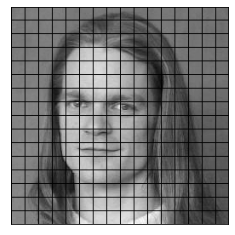

In [28]:
plt.imshow(arrF / 255, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

## 6 - Getting used to meshgrids (part 1)

In [30]:
arrF = imageRead('portrait.png')
m, n = arrF.shape
width_offset = 50
height_offset = 85
ci, cj = 128, 110

In [31]:
# Use meshgrid to create an index mask.
rs, cs = np.meshgrid(np.arange(m), np.arange(n), indexing='ij')

# For the ellipse use a similar formula like the unit circle
# Simply offset the origin by the defined center, and
# scale the height (y-axis) and width (x-axis) differently.
mask = ((rs-ci)**2 / height_offset**2 + (cs-cj)**2 / width_offset**2  <= 1)

# Apply the change to the image - in the area of the mask.
arrF[mask] = 255

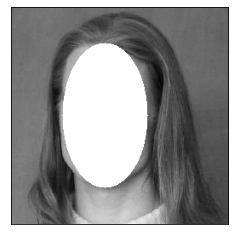

In [32]:
plt.imshow(arrF / 255, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

## 7 - Getting used to meshgrids (part 2)

In [35]:
arrF = imageRead('portrait.png')
radii = [32, 16, 64]

In [36]:
def circle_cutouts(arrF, r=32):
    m, n = arrF.shape

    # Create a meshgrid for only one circle (with diameter 2*r).
    rs, cs = np.meshgrid(np.arange(2*r), np.arange(2*r), indexing='ij')

    # Define the circle cutout.
    # Notice that the OUTSIDE of the circle is masked ('>').
    mask = ((rs-r)**2 + (cs-r)**2 > r**2)

    # Tile the circle as often as it fits in the dimensions
    mask = np.tile(mask, (m//(2*r), n//(2*r)))

    # Apply the mask
    arrG = np.copy(arrF)
    arrG[mask] = 255

    return arrG

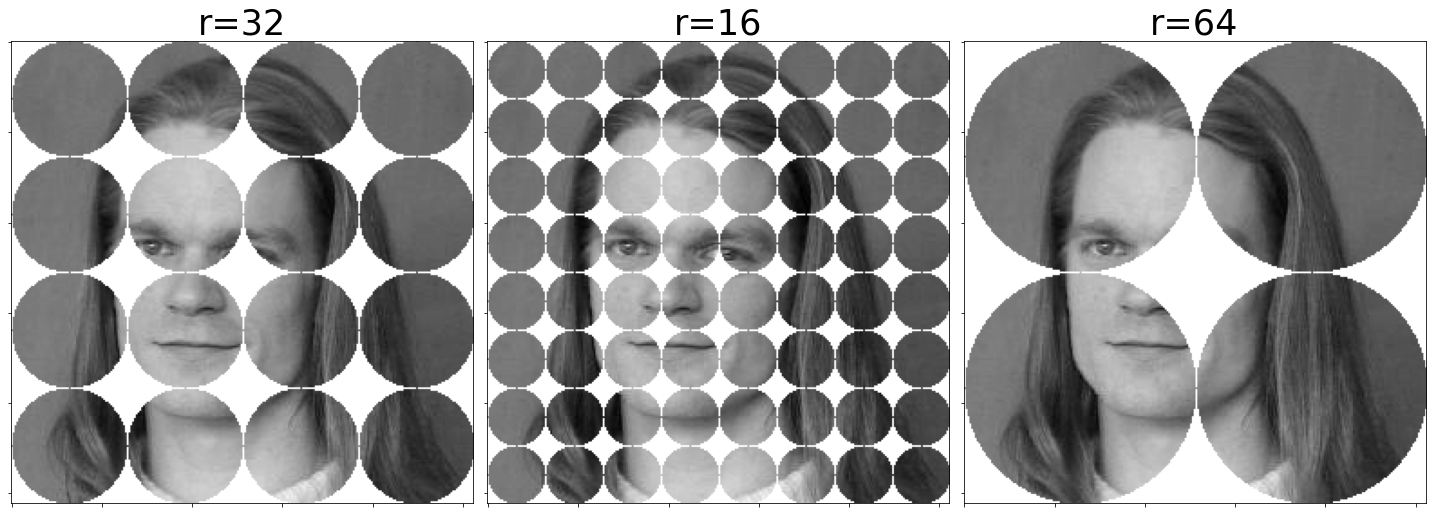

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i, radius in enumerate(radii):
    # Generate the image with the circle cutouts
    arrG = circle_cutouts(arrF, r=radius)

    # Arrange the image(s) in one figure
    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    
    ax.set_title(f"r={radius}", fontsize=35)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

#### Runtime measurements

In [ ]:
nRep =   3
nRun = 100
ts = timeit.Timer(functools.partial(circle_cutouts, arrF)).repeat(nRep, nRun)
print(f"{min(ts) / nRun} [sec]")

0.00025478838999788423 [sec]


## 8 - Getting used to meshgrids (part 3)

In [43]:
def sin_func(x, y, nu, n):
    sinus_term = np.sin(2 * np.pi * nu * x / (n-1) + np.pi / 2 * (n-1))
    return 0.5 * (sinus_term + 1) * 255

In [46]:
# Generate a meshgrid for all plots
xs, ys = np.meshgrid(np.arange(m), np.arange(n))

nu_list = [1., 2., 3., 9.]
m = n = 256

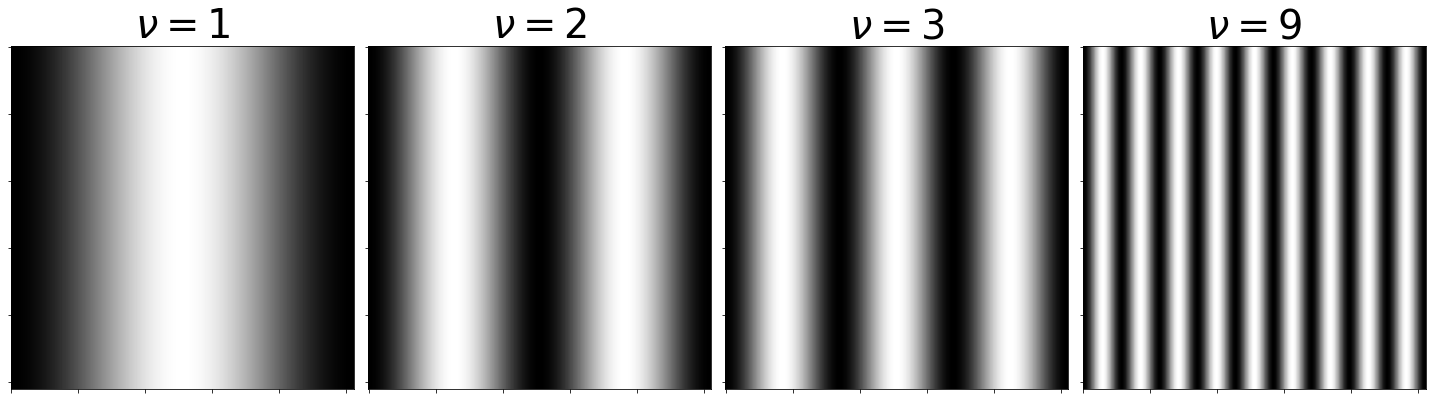

In [47]:
fig, axs = plt.subplots(1, len(nu_list), figsize=(20,20))

for i, nu in enumerate(nu_list):
    # Generate the image with the since function
    arrF = sin_func(xs, ys, nu, n)

    # Arrange the image(s) in one figure
    ax = axs[i]
    ax.imshow(arrF, cmap='gray')    
    ax.set_title(r"$\nu=$%i"%nu, fontsize=40)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

## 9 - Getting used to meshgrids (part 4)

In [50]:
def dampedVerticalSineWave(M, N, nu):
    xs, ys = np.meshgrid(np.arange(M), M-1-np.arange(N))
    return 0.5 * (np.exp(-4 / M * ys) * np.sin(2 * np.pi * nu * ys / (M-1) + np.pi / 2 * (M-1)) + 1) * 255

In [51]:
nu_list = [5., 9., 11., 13.]

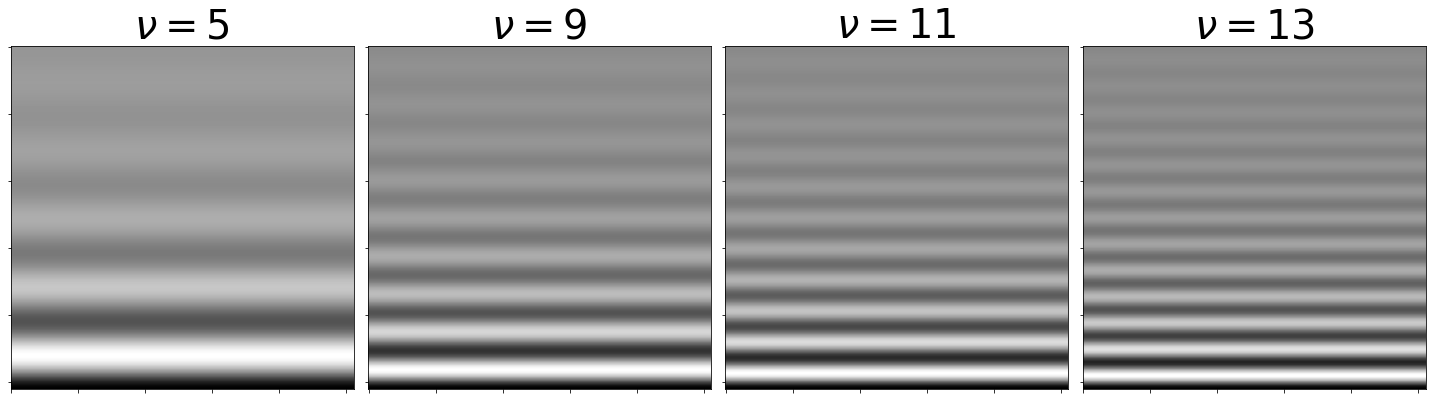

In [52]:
fig, axs = plt.subplots(1, len(nu_list), figsize=(20,20))

for i, nu in enumerate(nu_list):
    arrF = dampedVerticalSineWave(256, 256, nu)

    ax = axs[i]
    ax.imshow(arrF, cmap='gray')    
    ax.set_title(r"$\nu=$%i"%nu, fontsize=40)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

## 10 - Getting used to universal functions

In [53]:
def solarize(arrF, nu):
    return np.cos(arrF * nu * 2 * np.pi / 255.) * 127.5 + 127.5

In [54]:
nu_list = [0.5, 1.0, 1.5, 2.0]
arrF = imageRead('portrait.png')

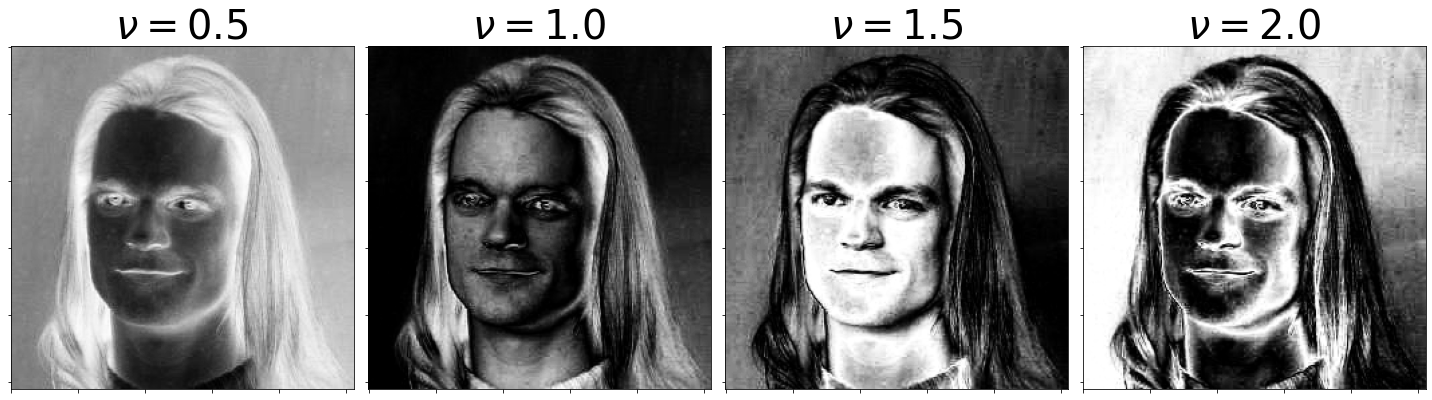

In [55]:
fig, axs = plt.subplots(1, len(nu_list), figsize=(20,20))

for i, nu in enumerate(nu_list):
    arrG = solarize(arrF, nu)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray')    

    ax.set_title(r"$\nu=$"+ f"{nu:.1f}", fontsize=40)
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()